# Comparisons

This is adapted from the given intro_coppelia file from near the beginning of Lehigh University's Mobile Robotics course.

In [62]:
# Import the python library that connects to CoppeliaSim, the file is sim.py.
try:
    import sim
except:
    print('--------------------------------------------------------------')
    print('"sim.py" could not be imported. This means very probably that')
    print('either "sim.py" or the remoteApi library could not be found.')
    print('Make sure both are in the same folder as this file,')
    print('or appropriately adjust the file "sim.py"')
    print('--------------------------------------------------------------')
    print('')

import time
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\wrist\Anaconda3\envs\handpose\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Check if python is connecting to Coppelia

In [63]:
print('Program started')
sim.simxFinish(-1)  # just in case, close all opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected to remote API server')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive. You can guarantee this with (for example):
    sim.simxGetPingTime(clientID)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
else:
    print('Failed connecting to remote API server')
print('Program ended')

Program started
Connected to remote API server
Program ended


# Object oriented programming

In [64]:
class robot():
    
    def __init__(self, motor_names, frame_name=None):        
        self.client_id = self.open_connection()
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame = self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object):
        relative_handle = self._get_handler(relative_object)
        sim.simxSetObjectPosition(clientID, self.frame, relative_handle, position, sim.simx_opmode_oneshot)
    
    def get_position(self, relative_object=-1):
        if relative_object != -1:
            relative_object = self.get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_position(self, object_name):
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)
    
    #For cuboid plotting: Get minimum and maximum x and y bounding box coords
    #using simxGetObjectIntParameter(clientID, objectHandle, parameterID, sim.simx_opmode_blocking)
    #where parameterID is 15 for minX, 18 for maxX, 16 for minY, and 19 for maxY.
    #Subtract minY from maxY to get height, subtract minX from maxX to get width.
    #Add global object origin position to minX and minY to get absolute positions of that corner.
    #Get rotation relative to world frame about Z axis.
    #Return minX, minY, width, height, rotation.
    def get_cuboid_plotting_data(self, object_name):
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        #global position
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        position.pop()
        #get rotation
        res, rotation=sim.simxGetObjectOrientation(clientID, object_h, -1, sim.simx_opmode_blocking)
        rotation = rotation[2]
        
        return rotation, position
    
    def get_cylinder_plotting_data(self, object_name):
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        #global position
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        position.pop()
        #radius
        res, radius = sim.simxGetObjectFloatParameter(clientID, object_h, 18, sim.simx_opmode_blocking)
        
        return position, radius

In [65]:
#Rotation function from stackoverflow user Mark Dickenson at this link: 
#https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def get_cuboid_obstacle(cuboidName,r):
    rotation, center = r.get_cuboid_plotting_data(cuboidName)
    circles = []
    obstacle = []
    circles.append([center[0], center[1]])
    circles.append([center[0] - 1.75, center[1]])
    circles.append([center[0] - 1.5, center[1]])
    circles.append([center[0] - 1, center[1]])
    circles.append([center[0] - .5, center[1]])
    circles.append([center[0] + .5, center[1]])
    circles.append([center[0] + 1, center[1]])
    circles.append([center[0] + 1.5, center[1]])
    circles.append([center[0] + 1.75, center[1]])
    #rotate circles by rotation
    for circle in circles:
        x, y = rotate(center, circle, rotation)
        obstacle.append([x, y])
    
    return obstacle

def get_cylinder_obstacle(cylinderName,r):
    position, radius = r.get_cylinder_plotting_data(cylinderName)
    cylinders = []
    cylinders.append([position[0], position[1]])
    cylinders.append([position[0] + .5, position[1]])
    cylinders.append([position[0], position[1] + .5])
    cylinders.append([position[0] - .5, position[1]])
    cylinders.append([position[0], position[1] -.5])

    return cylinders

# Construct Map of Scene

Now, we can construct a map of the scene using the robot class, as long as we know what all the scene obstacles are named.

In [80]:
#First, we get the obstacle and goal coordinates

# Joint names in coppelia for KUKA omnidirectional robot
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']

r = robot(motor_names, 'Omnirob')  # Create an instance of our robot

#Set scaling factors for goal potential and obstacle potential
obsK = .9
goalK = 0.15

#get robot position
robotXY = r.get_position().tolist()
robotXY.pop()

#get goal position
goal = [7.1, -8.6]
#append goal K value
goal.append(goalK)

#get obstacle positions
obstacles = []
obstacles += get_cuboid_obstacle("Cuboid0", r)
obstacles += get_cuboid_obstacle("Cuboid1", r)
obstacles += get_cuboid_obstacle("Cuboid3", r)
obstacles += get_cuboid_obstacle("Cuboid4", r)
obstacles += get_cuboid_obstacle("Cuboid6", r)
obstacles += get_cylinder_obstacle("Cylinder5", r)
obstacles += get_cylinder_obstacle("Cylinder6", r)
obstacles += get_cylinder_obstacle("Cylinder7", r)
obstacles += get_cylinder_obstacle("Cylinder8", r)
obstacles += get_cylinder_obstacle("Cylinder9", r)
obstacles += get_cylinder_obstacle("Cylinder10", r)
obstacles += get_cylinder_obstacle("Cylinder11", r)
obstacles += get_cylinder_obstacle("Cylinder12", r)
#append obstacle K value
obstaclesK = np.zeros((len(obstacles), 1))#.fill(0.04).tolist()
obstaclesK.fill(obsK)
obstacles = np.hstack((np.asarray(obstacles), obstaclesK)).tolist()

r.close_connection()

Robot connected
Connection closed


In [81]:
#Next, we plot the map without the vector field

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

def get_obstacle_patches(obstacles, radius):
    obstacleList = []
    for obstacle in obstacles:
        obstacleList.append(Circle((obstacle[0], obstacle[1]), radius))
        
    obstaclePatches = PatchCollection(obstacleList, facecolor='k')
        
    return obstaclePatches

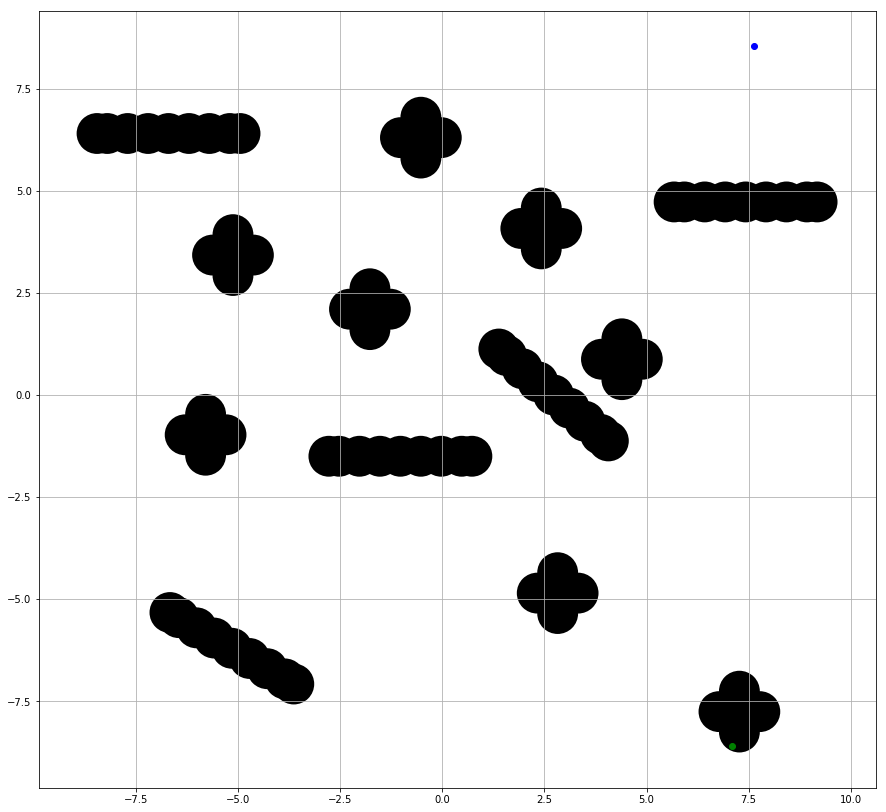

In [82]:
preview_figure = plt.figure(figsize(15,15))
preview_show = preview_figure.add_subplot(111)

preview_show.add_collection(get_obstacle_patches(obstacles, 0.5))
plt.plot(robotXY[0], robotXY[1], 'bo', goal[0], goal[1], 'go')

plt.grid()
preview_show.set_aspect('equal', adjustable='box')

# Construct Vector Field

Now that we have our map, we can add a vector field for our virtual potential field

In [83]:
# Functions for calculating vector field

# get the cumulative force incorporating each obstacle and goal given a certain position
def get_force_vectors(obstacleList, goal, position):
    #Calculate goal force
    xForceGoal = goal[2] * (goal[0] - position[0])
    yForceGoal = goal[2] * (goal[1] - position[1])
    force = np.array([xForceGoal, yForceGoal])
    
    #Calculate obstacle forces, adding goal force each time
    for obstacle in obstacles:
        #Get distances between current position and obstacle
        xDistance = position[0] - obstacle[0]
        yDistance = position[1] - obstacle[1]
        
        obstacleDistance = sqrt(xDistance**2 + yDistance**2)
        
        #Use those distances and k-values to compute the force
        
        #Derivative of potential function:
        potentialDeriv = (obstacle[2] / (obstacleDistance**3))
        
        #Direction of force (partial derivatives of distance function)
        xForceDir = (xDistance / obstacleDistance)
        yForceDir = (yDistance / obstacleDistance)
        
        #Forces
        xForce = potentialDeriv * xForceDir
        yForce = potentialDeriv * yForceDir
        
        force[0] = force[0] + xForce
        force[1] = force[1] + yForce
        
    return force[0], force[1]

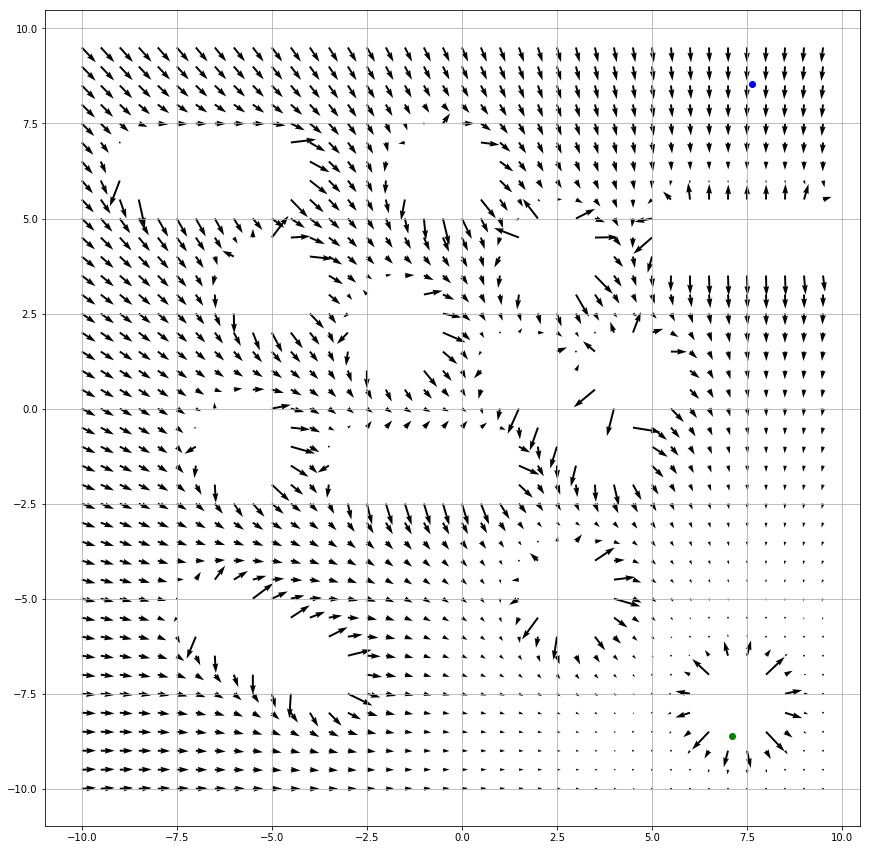

In [84]:
#This section adapted from Dr. David Saldana's code at the following link:
#https://github.com/dsaldana/CSE360-MobileRobotics/blob/master/Potential_functions.ipynb

#Grid of visualized vectors
X, Y = np.meshgrid(np.arange(-10, 10, .5), np.arange(-10, 10, .5))
#Get forces for visualized vector points
xForce, yForce = get_force_vectors(obstacles, goal, [X, Y])

#Show forces
preview_figure = plt.figure(figsize(15,15))
preview_show = preview_figure.add_subplot(111)

#preview_show.add_collection(get_obstacle_patches(obstacles, 0.5))
plt.plot(robotXY[0], robotXY[1], 'bo', goal[0], goal[1], 'go')

#Eliminate any vectors that are beyond a certain length
vectorLength = np.hypot(xForce, yForce)
xForce[vectorLength > 5], yForce[vectorLength > 5] = None, None

#Plot vector field
plt.quiver(X, Y, xForce, yForce)

plt.grid()
preview_show.set_aspect('equal', adjustable='box')

# Guide Robot to Destination

Now that we have the virtual potential field, we can have the robot follow it to the goal.

In [ ]:
# Robot movement function. Basic motor velocities for moving in the
# positive x axis and the positive y axis, can scale them and then combine them
# to move in any direction.

def move(xScale, yScale, r):
    motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
    #basic x-axis movement
    xMotor = np.array([-1., -1., 1., 1.])
    yMotor = np.array([-1., 1., 1., -1.])
    r.send_motor_velocities(xScale * xMotor + yScale * yMotor)



r = robot(motor_names, 'Omnirob')  # Create an instance of our robot

timeStep = 0
while(timeStep < 50000):
    #calculate next direction
    roboPos = r.get_position()
    x, y = get_force_vectors(obstacles, goal, [roboPos[0], roboPos[1]])
    print(x)
    print(y)
    print()
    move(x, y, r)
    time.sleep(0.01)
    timeStep += 1

move(0, 0, r)

r.close_connection()

Robot connected
-0.03798176129275047
-2.414638474582096
()
-0.03798161318332088
-2.4146357133286096
()
-0.037562346598398376
-2.4072803371603766
()
-0.0369729802690897
-2.397527316586023
()
-0.03657672135468491
-2.3909628894620325
()
-0.035979190462104994
-2.381039570172347
()
-0.035376095890905505
-2.3709986349271635
()
-0.03497107482605091
-2.3642432168030343
()
-0.03436145943002246
-2.3540330308162374
()
-0.03395289182745133
-2.347165854347166
()
-0.03354209021530345
-2.3402465792548863
()
-0.03292119634150914
-2.3297599503246027
()
-0.03250399045542848
-2.322691208982819
()
-0.032084926854793194
-2.3155751729149006
()
-0.03166404939662431
-2.3084061510057508
()
-0.031026918749340417
-2.29751969392174
()
-0.030598177302801004
-2.2901723094780224
()
-0.029951257269732207
-2.279043311122609
()
-0.02929818903353625
-2.267754884566544
()
-0.028639182677012487
-2.256306415059027
()
-0.02797485827888302
-2.2446929329528147
()
-0.0275286783738651
-2.2368534069046713
()
-0.02708001227430823

0.02605396527127538
-0.003883926769186331
()
0.026053074300676736
-0.0037408425994400795
()
0.026051679942414387
-0.003539617224813304
()
0.026050303928728064
-0.003336473062381675
()
0.02604877415729689
-0.003164029435028865
()
0.02604773298742361
-0.0030535578890914096
()
0.026046682486711395
-0.0029450212896269105
()
0.02604503936262418
-0.002799431198584346
()
0.026043957407377766
-0.0027004648735458347
()
0.026042822189161024
-0.0026148847787621854
()
0.026041071281186892
-0.0024942666814406636
()
0.026039311866785278
-0.0023774940399394285
()
0.02603754138279853
-0.0022645787791547457
()
0.02603568820516712
-0.0021708435028955104
()
0.02603443062146422
-0.002114112364666995
()
0.02603256888845812
-0.00202614689528521
()
0.026030706657925867
-0.0019420003745736773
()
0.026028819397709933
-0.0018655322282616273
()
0.026027582725800743
-0.0018107428347366311
()
0.02602627341310104
-0.0017713101216112847
()
0.026024322135493515
-0.0017084086242744243
()
0.0260229813180265
-0.00167857

0.02588264160810503
-0.0009670218116762527
()
0.025882784875488684
-0.0009603299084167773
()
0.025882914982593958
-0.0009574736198285617
()
0.025883110235185778
-0.0009560444102151386
()
0.025883297007642875
-0.0009474363345272161
()
0.025883471273457206
-0.0009556528569847727
()
0.025883580085352072
-0.000964327520768077
()
0.0258838899500574
-0.0009552647384003347
()
0.025884108504586646
-0.0009654249308445838
()
0.02588436940423938
-0.0009717067522050384
()
0.025884685410192593
-0.0009722476756290301
()
0.025885033084425996
-0.0009708498900855458
()
0.02588526505292029
-0.0009718365836561915
()
0.025885368730809082
-0.0009752512997628921
()
0.02588562607822621
-0.0009743210338493765
()
0.02588587092938318
-0.0009772604002125308
()
0.02588609069892016
-0.0009859541453996158
()
0.025886454028476807
-0.0009715336052939902
()
0.025886898666637126
-0.0009701196166560755
()
0.025887365608095105
-0.0009687401910922911
()
0.025887830551026815
-0.0009711981345542689
()
0.02588812100565005
-0

0.026108649642601272
-0.0010146258000764195
()
0.026110928379310346
-0.001004281954327423
()
0.02611311424150669
-0.001007391019272577
()
0.026116438038229512
-0.0010101636771034498
()
0.026118662922024364
-0.001013310011632494
()
0.026122081645676472
-0.0010103447409475135
()
0.026125431081630006
-0.0010248037659916264
()
0.02612997267555505
-0.0010330412448596043
()
0.026133424907827503
-0.001037795633769221
()
0.026135678830509095
-0.0010506180604744188
()
0.026138042933056063
-0.0010479983803209879
()
0.026141684768131838
-0.0010354394202974127
()
0.026145292251099964
-0.0010286030655521363
()
0.026148929722229364
-0.001023748325380682
()
0.026151358087564296
-0.001025070381774454
()
0.02615375984161106
-0.0010282473154774733
()
0.026156230529404224
-0.0010237258045358224
()
0.026159943250684027
-0.0010188678253484653
()
0.026163701281578876
-0.0010101338967821501
()
0.026166157403943537
-0.0010133057870311405
()
0.026168655962262945
-0.0010126345937058585
()
0.026171250819252544
-

# Plot Paths for BFS and A*

In [7]:
#Rotation function from stackoverflow user Mark Dickenson at this link: 
#https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def get_cuboid_obstacle(cuboidName,r):
    rotation, center = r.get_cuboid_plotting_data(cuboidName)
    circles = []
    obstacle = []
    circles.append([center[0] - 1.5, center[1]])
    circles.append([center[0] - .5, center[1]])
    circles.append([center[0] + .5, center[1]])
    circles.append([center[0] + 1.5, center[1]])
    #rotate circles by rotation
    for circle in circles:
        x, y = rotate(center, circle, rotation)
        obstacle.append([x, y])
    
    return obstacle

def get_cylinder_obstacle(cylinderName,r):
    position, radius = r.get_cylinder_plotting_data(cylinderName)
    cylinders = []
    cylinders.append([position[0], position[1]])

    return cylinders

In [12]:
#First, we get the obstacle and goal coordinates

# Joint names in coppelia for KUKA omnidirectional robot
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']

r = robot(motor_names, 'Omnirob')  # Create an instance of our robot

#get robot position
robotXY = r.get_position().tolist()
robotXY.pop()

#get goal position
goal = [7.1, -8.6]

#get obstacle positions
obstacles = []
obstacles += get_cuboid_obstacle("Cuboid0", r)
obstacles += get_cuboid_obstacle("Cuboid1", r)
obstacles += get_cuboid_obstacle("Cuboid3", r)
obstacles += get_cuboid_obstacle("Cuboid4", r)
obstacles += get_cuboid_obstacle("Cuboid6", r)
obstacles += get_cylinder_obstacle("Cylinder5", r)
obstacles += get_cylinder_obstacle("Cylinder6", r)
obstacles += get_cylinder_obstacle("Cylinder7", r)
obstacles += get_cylinder_obstacle("Cylinder8", r)
obstacles += get_cylinder_obstacle("Cylinder9", r)
obstacles += get_cylinder_obstacle("Cylinder10", r)
obstacles += get_cylinder_obstacle("Cylinder11", r)
obstacles += get_cylinder_obstacle("Cylinder12", r)

r.close_connection()

Robot connected
Connection closed


In [13]:
#Next, we plot the map without the discretization grid

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

def get_obstacle_patches(obstacles, radius):
    obstacleList = []
    for obstacle in obstacles:
        obstacleList.append(Circle((obstacle[0], obstacle[1]), radius))
        
    obstaclePatches = PatchCollection(obstacleList, facecolor='k')
        
    return obstaclePatches

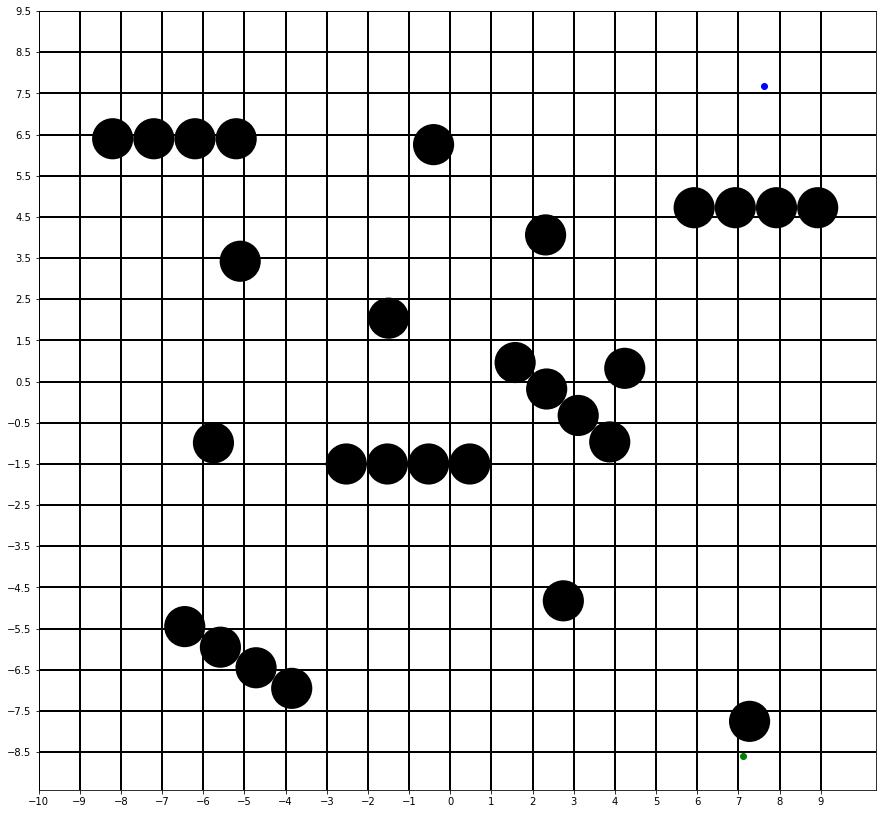

In [27]:
grainSize = 1

preview_figure = plt.figure(figsize(15,15))
preview_show = preview_figure.add_subplot(111)

preview_show.add_collection(get_obstacle_patches(obstacles, 0.5))
plt.plot(robotXY[0], robotXY[1], 'bo', goal[0], goal[1], 'go')

plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
preview_show.set_xticks(np.arange(-10, 10, grainSize));
preview_show.set_yticks(np.arange(-8.5, 10, grainSize));
preview_show.set_aspect('equal', adjustable='box')

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.

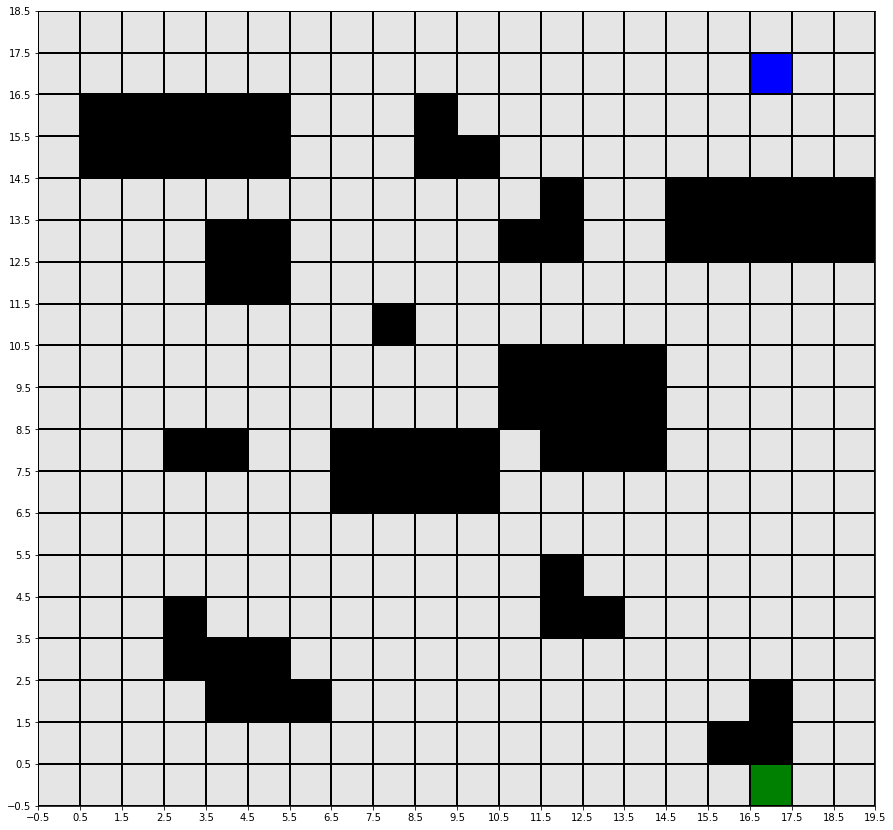

In [48]:
from matplotlib import colors

# This cell modified from Dr. David Saldana's code at this link:
# https://github.com/dsaldana/CSE360-MobileRobotics/blob/master/Grid_bfs.ipynb

grid_cells = np.zeros((19,20))

grid_cells[2,1] = 1
grid_cells[2,2] = 1
grid_cells[2,3] = 1
grid_cells[2,4] = 1
grid_cells[2,5] = 1
grid_cells[2,9] = 1

grid_cells[3,1] = 1
grid_cells[3,2] = 1
grid_cells[3,3] = 1
grid_cells[3,4] = 1
grid_cells[3,5] = 1
grid_cells[3,9] = 1
grid_cells[3,10] = 1

grid_cells[4,12] = 1
grid_cells[4,15] = 1
grid_cells[4,16] = 1
grid_cells[4,17] = 1
grid_cells[4,18] = 1
grid_cells[4,19] = 1

grid_cells[5,4] = 1
grid_cells[5,5] = 1
grid_cells[5,11] = 1
grid_cells[5,12] = 1
grid_cells[5,15] = 1
grid_cells[5,16] = 1
grid_cells[5,17] = 1
grid_cells[5,18] = 1
grid_cells[5,19] = 1

grid_cells[6,4] = 1
grid_cells[6,5] = 1

grid_cells[7,8] = 1

grid_cells[8,11] = 1
grid_cells[8,12] = 1
grid_cells[8,13] = 1
grid_cells[8,14] = 1

grid_cells[9,11] = 1
grid_cells[9,12] = 1
grid_cells[9,13] = 1
grid_cells[9,14] = 1

grid_cells[10,3] = 1
grid_cells[10,4] = 1
grid_cells[10,7] = 1
grid_cells[10,8] = 1
grid_cells[10,9] = 1
grid_cells[10,10] = 1
grid_cells[10,12] = 1
grid_cells[10,13] = 1
grid_cells[10,14] = 1

grid_cells[11,7] = 1
grid_cells[11,8] = 1
grid_cells[11,9] = 1
grid_cells[11,10] = 1

grid_cells[13,12] = 1

grid_cells[14,3] = 1
grid_cells[14,12] = 1
grid_cells[14,13] = 1

grid_cells[15,3] = 1
grid_cells[15,4] = 1
grid_cells[15,5] = 1

grid_cells[16,4] = 1
grid_cells[16,5] = 1
grid_cells[16,6] = 1
grid_cells[16,17] = 1

grid_cells[17,16] = 1
grid_cells[17,17] = 1

#Goal and start
grid_cells[1,17] = 2
grid_cells[18,17] = 3

grid_cells = np.flip(grid_cells, 0)

print(grid_cells)

# Plot the grid
def draw_grid():
    fig, ax = plt.subplots()
    cmap = colors.ListedColormap(['0.9', 'black', 'blue', 'green']) # Colors (0.9 is the almost white in gray scale)
    ax.imshow(grid_cells, cmap=cmap, origin='lower')
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, 20, grainSize));
    ax.set_yticks(np.arange(-.5, 19, grainSize));

draw_grid()

# Breadth First Search Test

('Number of nodes in a full grid (13 * 12): ', 380)
('Number of nodes after removing obstacles: ', 315)
('Nodes:', NodeView(((7, 3), (18, 19), (8, 5), (9, 0), (10, 7), (0, 17), (14, 1), (12, 17), (3, 2), (4, 5), (16, 0), (17, 13), (18, 10), (9, 9), (8, 18), (11, 15), (9, 19), (14, 8), (12, 8), (15, 13), (13, 13), (2, 18), (0, 14), (3, 11), (1, 15), (2, 12), (5, 1), (3, 17), (16, 7), (6, 14), (17, 6), (7, 15), (18, 5), (10, 9), (11, 4), (12, 7), (10, 19), (13, 6), (0, 5), (1, 0), (4, 11), (2, 7), (5, 10), (6, 1), (4, 17), (7, 4), (17, 17), (8, 0), (15, 19), (11, 19), (16, 11), (6, 18), (17, 10), (18, 17), (9, 6), (10, 5), (0, 19), (14, 7), (12, 19), (1, 18), (15, 6), (0, 9), (4, 7), (5, 6), (17, 3), (7, 16), (18, 8), (9, 15), (11, 1), (9, 17), (14, 14), (12, 10), (15, 15), (2, 16), (0, 0), (3, 13), (1, 13), (4, 14), (2, 10), (5, 15), (3, 19), (6, 12), (17, 4), (18, 3), (11, 6), (12, 1), (10, 17), (0, 7), (1, 6), (5, 8), (6, 7), (4, 19), (7, 6), (5, 18), (8, 2), (9, 3), (14, 2), (3, 1), 

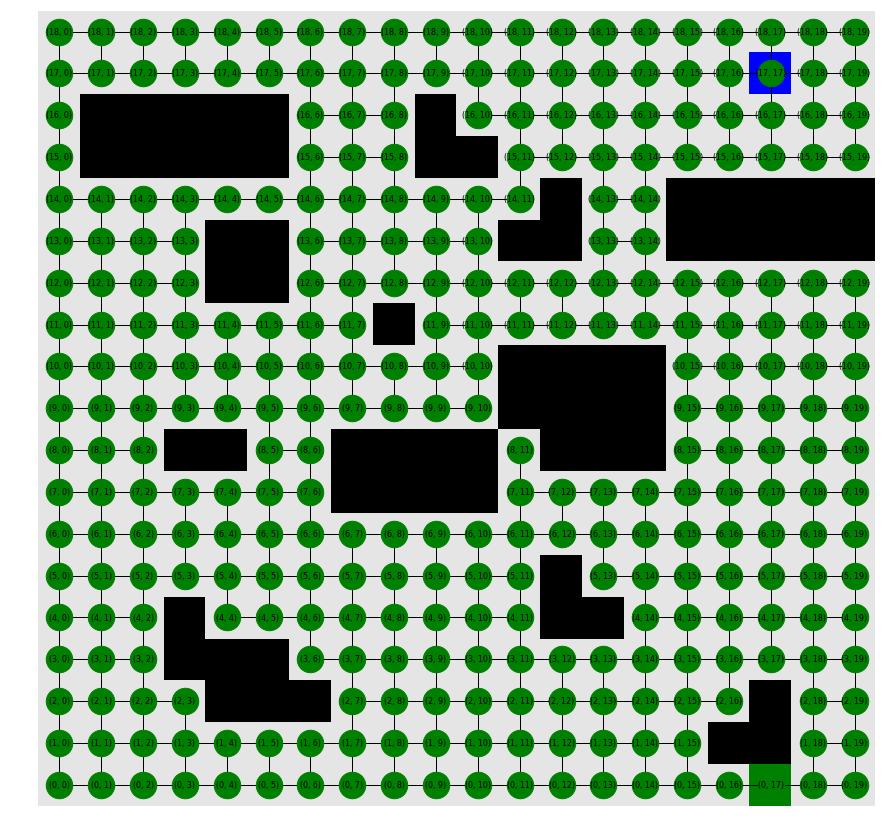

In [55]:
# This cell modified from Dr. David Saldana's code at this link:
# https://github.com/dsaldana/CSE360-MobileRobotics/blob/master/Grid_bfs.ipynb

import networkx as nx
# This function automatically creates the graph in a grid.
G = nx.grid_2d_graph(19, 20) 
print("Number of nodes in a full grid (19 * 20): ",len(G.nodes()))
# Delete nodes with obstacles
for i in range(19):
    for j in range(20):
        # if the node is an obstacle
        if grid_cells[i][j] == 1:  
            G.remove_node((i,j))

print("Number of nodes after removing obstacles: ",len(G.nodes()))
print("Nodes:", G.nodes())

# Position of the nodes
pos = {node:(node[1], node[0]) for node in G.nodes()}  # by making (x,y) = (j, i), where i and j iterate over the columns and the rows respectively.
draw_grid()
nx.draw(G, pos, font_size=8, with_labels=True, node_size=700, node_color="g")


[(17, 17), (16, 17), (16, 16), (15, 16), (15, 15), (15, 14), (14, 14), (13, 14), (12, 14), (12, 15), (11, 15), (10, 15), (9, 15), (8, 15), (7, 15), (6, 15), (5, 15), (4, 15), (3, 15), (2, 15), (1, 15), (0, 15), (0, 16), (0, 17)]


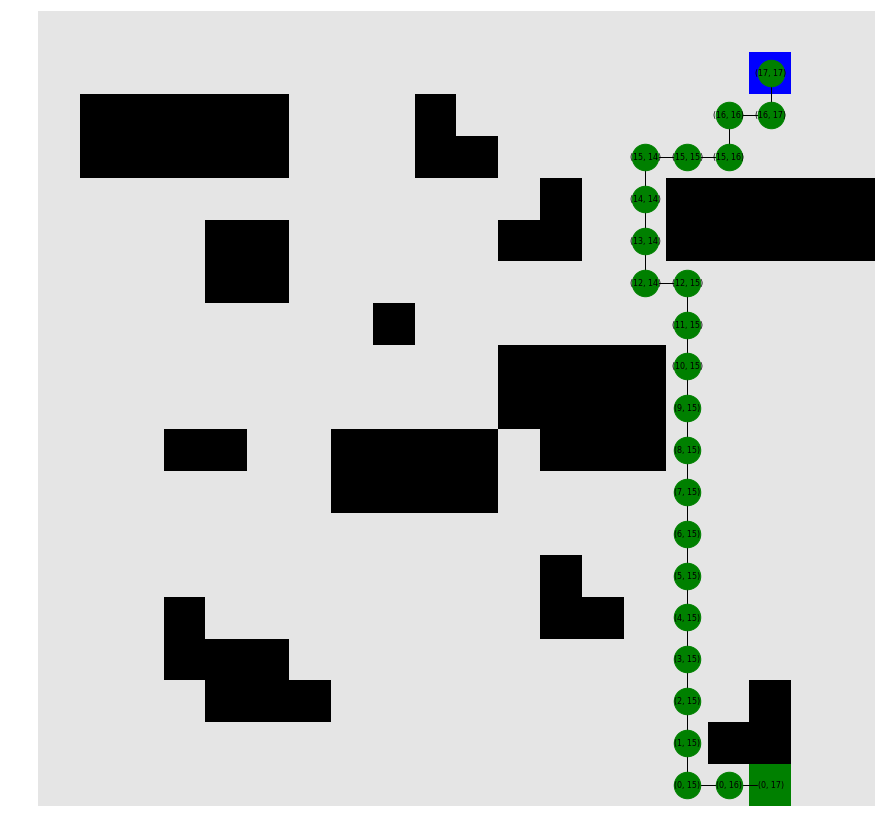

In [59]:
# This cell modified from Dr. David Saldana's code at this link:
# https://github.com/dsaldana/CSE360-MobileRobotics/blob/master/Grid_bfs.ipynb

#Networkx BFS algorithm
tree = nx.bfs_tree(G, (17,17))
pos = {node:(node[1], node[0]) for node in G.nodes()}  # by making (x,y) = (j, i), where i and j iterate over the columns and the rows respectively.

#Back-propagate from goal node (0,17) and add nodes to start
startNode = (17,17)

curr = (0,17)
path = [curr]
while curr != startNode:
    for node in tree.predecessors(curr):
        path.append(node)
        curr = node
        
path.reverse()
print(path)

# Delete nodes not in path
for i in range(19):
    for j in range(20):
        # if the node is an obstacle
        if not G.has_node((i,j)):
            continue
        if (i,j) not in path:  
            G.remove_node((i,j))
pos = {node:(node[1], node[0]) for node in G.nodes()}  # by making (x,y) = (j, i), where i and j iterate over the columns and the rows respectively.
draw_grid()
nx.draw(G, pos, font_size=8, with_labels=True, node_size=700, node_color="g")

# A* Test

('Number of nodes in a full grid (13 * 12): ', 380)
('Number of nodes after removing obstacles: ', 315)
('Nodes:', NodeView(((7, 3), (18, 19), (8, 5), (9, 0), (10, 7), (0, 17), (14, 1), (12, 17), (3, 2), (4, 5), (16, 0), (17, 13), (18, 10), (9, 9), (8, 18), (11, 15), (9, 19), (14, 8), (12, 8), (15, 13), (13, 13), (2, 18), (0, 14), (3, 11), (1, 15), (2, 12), (5, 1), (3, 17), (16, 7), (6, 14), (17, 6), (7, 15), (18, 5), (10, 9), (11, 4), (12, 7), (10, 19), (13, 6), (0, 5), (1, 0), (4, 11), (2, 7), (5, 10), (6, 1), (4, 17), (7, 4), (17, 17), (8, 0), (15, 19), (11, 19), (16, 11), (6, 18), (17, 10), (18, 17), (9, 6), (10, 5), (0, 19), (14, 7), (12, 19), (1, 18), (15, 6), (0, 9), (4, 7), (5, 6), (17, 3), (7, 16), (18, 8), (9, 15), (11, 1), (9, 17), (14, 14), (12, 10), (15, 15), (2, 16), (0, 0), (3, 13), (1, 13), (4, 14), (2, 10), (5, 15), (3, 19), (6, 12), (17, 4), (18, 3), (11, 6), (12, 1), (10, 17), (0, 7), (1, 6), (5, 8), (6, 7), (4, 19), (7, 6), (5, 18), (8, 2), (9, 3), (14, 2), (3, 1), 

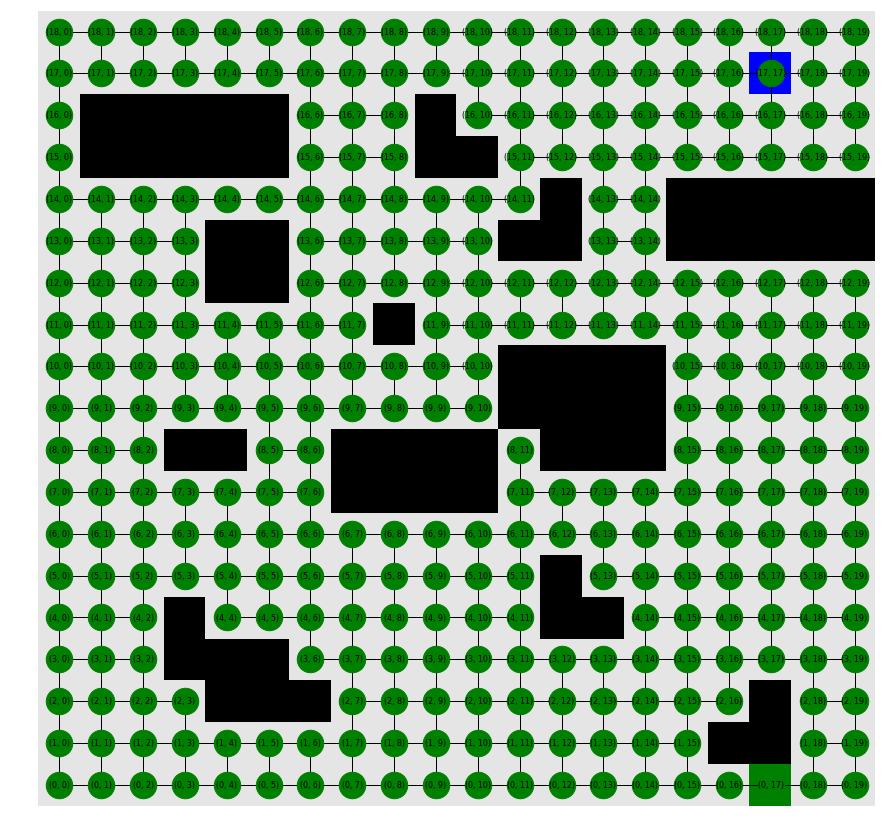

In [60]:
# This function automatically creates the graph in a grid.
G = nx.grid_2d_graph(19, 20) 
print("Number of nodes in a full grid (19 * 20): ",len(G.nodes()))
# Delete nodes with obstacles
for i in range(19):
    for j in range(20):
        # if the node is an obstacle
        if grid_cells[i][j] == 1:  
            G.remove_node((i,j))

print("Number of nodes after removing obstacles: ",len(G.nodes()))
print("Nodes:", G.nodes())

# Position of the nodes
pos = {node:(node[1], node[0]) for node in G.nodes()}  # by making (x,y) = (j, i), where i and j iterate over the columns and the rows respectively.
draw_grid()
nx.draw(G, pos, font_size=8, with_labels=True, node_size=700, node_color="g")


[(17, 17), (16, 17), (15, 17), (15, 16), (15, 15), (15, 14), (14, 14), (13, 14), (12, 14), (11, 14), (11, 15), (10, 15), (9, 15), (8, 15), (7, 15), (6, 15), (5, 15), (4, 15), (3, 15), (2, 15), (1, 15), (0, 15), (0, 16), (0, 17)]


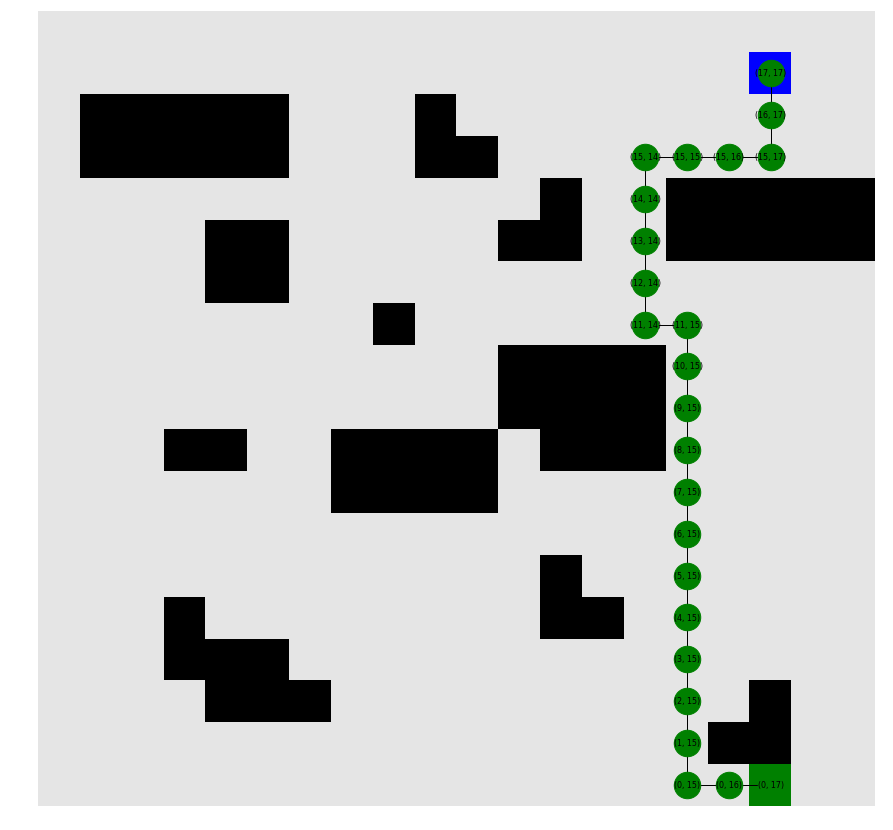

In [61]:
# This cell modified from Dr. David Saldana's code at this link:
# https://github.com/dsaldana/CSE360-MobileRobotics/blob/master/Grid_bfs.ipynb

#A* heuristic function (Euclidean distance)
def euclidean_distance(node1, node2):
    return sqrt((node1[0] - node2[0])**2 + (node1[1] - node2[1])**2)

#Networkx A* algorithm
path = nx.astar_path(G, (17,17), (0,17), euclidean_distance)

# Delete nodes not in path
for i in range(19):
    for j in range(20):
        # if the node is an obstacle
        if not G.has_node((i,j)):
            continue
        if (i,j) not in path:  
            G.remove_node((i,j))
pos = {node:(node[1], node[0]) for node in G.nodes()}  # by making (x,y) = (j, i), where i and j iterate over the columns and the rows respectively.
draw_grid()
nx.draw(G, pos, font_size=8, with_labels=True, node_size=700, node_color="g")


print(path)